<hr>
<center><h2>Image Captioning</h2></center>
<hr>

## 1. Loading the data


Importing all necessaray packages, loading the dataand creating session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
captions_df = pd.read_csv("../archive/captions.txt")
captions_df.head(n=10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [3]:
captions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [4]:
captions_df = captions_df.drop_duplicates(["image"])
captions_df.head(n=10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
10,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
15,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
20,1007129816_e794419615.jpg,A man in an orange hat starring at something .
25,1007320043_627395c3d8.jpg,A child playing on a rope net .
30,1009434119_febe49276a.jpg,A black and white dog is running in a grassy g...
35,1012212859_01547e3f17.jpg,"A dog shakes its head near the shore , a red b..."
40,1015118661_980735411b.jpg,A boy smiles in front of a stony wall in a city .
45,1015584366_dfcec3c85a.jpg,A black dog leaps over a log .


In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prabhatks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from tqdm import tqdm
from nltk.stem import PorterStemmer
import re

stemmer = PorterStemmer()
def pre_process_text(sentence, add_space=False):
    special_chars_remover = re.compile(r'[^a-zA-Z]')
    new_sentence = ""
    refined_sen = special_chars_remover.sub(' ', sentence)
    refined_sen = refined_sen.lower()
    for word in refined_sen.split():
        if word not in stop_words and len(word) > 1:
            new_sentence += word + " "
    if add_space:
        return new_sentence.strip() + " "
    return new_sentence.strip()

In [7]:
pre_process_text("Bike is making a left turn")

'bike making left turn'

In [8]:
captions_df["caption"] = captions_df["caption"].apply(pre_process_text)
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,child pink dress climbing set stairs entry way
5,1001773457_577c3a7d70.jpg,black dog spotted dog fighting
10,1002674143_1b742ab4b8.jpg,little girl covered paint sits front painted r...
15,1003163366_44323f5815.jpg,man lays bench dog sits
20,1007129816_e794419615.jpg,man orange hat starring something


In [9]:
captions_df.shape

(8091, 2)

<hr>

## 2. GPT Model

Using the GPT model to form sentences 

In [10]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

/Users/prabhatks/miniconda3/envs/image_caption/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt_model.eval()

/Users/prabhatks/miniconda3/envs/image_caption/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [12]:
"""
save_directory = "../output/gpt2_local/"
tokenizer.save_pretrained(f"{save_directory}/tokenizer/")
gpt_model.save_pretrained(f"{save_directory}/model/")
"""

'\nsave_directory = "../output/gpt2_local/"\ntokenizer.save_pretrained(f"{save_directory}/tokenizer/")\ngpt_model.save_pretrained(f"{save_directory}/model/")\n'

In [13]:
# Set eos_token as pad_token
tokenizer.pad_token = tokenizer.eos_token
pad_token_id = tokenizer.pad_token_id

In [14]:
# Function to generate sentence from input words with padding and attention mask
def generate_sentence(words, max_new_tokens=50):
    input_text = " ".join(words)
    encoding = tokenizer.encode_plus(
        input_text,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=100,  # This is the length of input tokens
        return_attention_mask=True
    )
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    
    # Move to device if needed
    input_ids = input_ids.to(gpt_model.device)
    attention_mask = attention_mask.to(gpt_model.device)
    
    with torch.no_grad():
        output_ids = gpt_model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,  # Generate up to 50 new tokens
            pad_token_id=pad_token_id
        )
    
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    
    # refining the output from gpt
    if "\n\n" in output_text:
        output_text = output_text.split("\n\n")[1]
    return output_text


In [15]:
test_data = ["bike", "two", "wheeler"]
generate_sentence(test_data)

'The car is powered by a 2.0-litre V8 engine and a petrol engine.'

<hr>

## 3. Using imagenet

Using imagenet to find the tokens

In [16]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

import keras

from sklearn.metrics.pairwise import cosine_similarity

In [17]:
model = VGG16(weights='imagenet')
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

We can either analyse all components of image by creating a window and run it though the image, or analyse the whole image in one go

In [18]:
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

In [19]:
image_dir = "../archive/Images/"

In [20]:
def extract_weights_from_image(img_path):
    last_conv_layer_name = "fc2"
    img_path = str(img_path)
    # Load the model and cut off the last layer
    model_without_last_step = tf.keras.Model(
        model.inputs, model.get_layer(last_conv_layer_name).output
    )

    # Load and preprocess the image
    img = image.load_img(f"{image_dir}/{img_path}", target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Get the output of the last convolutional layer
    last_conv_layer_output = model_without_last_step.predict(img_array)
    
    # Convert numpy array to a Python list
    return last_conv_layer_output.flatten().tolist()

In [21]:
train_df = captions_df[:6000]
test_df = captions_df[6000:]

In [22]:
train_df.shape, test_df.shape

((6000, 2), (2091, 2))

In [23]:
# train_df["weights"] = train_df["image"].apply(extract_weights_from_image)

In [24]:
# train_df.to_parquet("../output/imageNet_weights.parquet")

In [25]:
train_df = pd.read_parquet("../output/imageNet_weights.parquet")

In [26]:
train_df.head(10)

,image,caption,weights
0,1000268201_693b08cb0e.jpg,child pink dress climbing set stairs entry way,"[2.507473945617676, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
5,1001773457_577c3a7d70.jpg,black dog spotted dog fighting,"[0.0, 0.0, 0.494147926568985, 0.0, 0.0, 0.0, 0..."
10,1002674143_1b742ab4b8.jpg,little girl covered paint sits front painted r...,"[1.4937913417816162, 0.0, 0.5356748104095459, ..."
15,1003163366_44323f5815.jpg,man lays bench dog sits,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.747..."
20,1007129816_e794419615.jpg,man orange hat starring something,"[0.0, 0.09227663278579712, 0.0, 0.388270735740..."
25,1007320043_627395c3d8.jpg,child playing rope net,"[0.0, 0.0, 0.0, 9.22694206237793, 0.0, 2.84540..."
30,1009434119_febe49276a.jpg,black white dog running grassy garden surround...,"[2.0965170860290527, 2.119253158569336, 3.5619..."
35,1012212859_01547e3f17.jpg,dog shakes head near shore red ball next,"[0.0, 0.0, 0.9873728156089783, 0.0, 0.0, 0.0, ..."
40,1015118661_980735411b.jpg,boy smiles front stony wall city,"[1.4410276412963867, 0.28291240334510803, 0.0,..."
45,1015584366_dfcec3c85a.jpg,black dog leaps log,"[0.7002905607223511, 0.0, 1.2561566829681396, ..."


In [27]:
test_df.head(20)

,image,caption
30000,3509575615_653cbf01fc.jpg,crowd standing front building holding newspape...
30005,3509611207_7645b1d28d.jpg,young group girls covering hair posing togethe...
30010,3510218982_318f738b76.jpg,boxer practicing making hits targeting gloves ...
30015,3510219078_670b6b3157.jpg,black dog brown white dog running playing
30020,3510695264_ef460fa6cc.jpg,group men white hard hats inside industrial bu...
30025,3511062827_cd87871c67.jpg,black dog pulling purple object mouth
30030,3511890331_6163612bb9.jpg,jockey blue gallops chestnut horse dirt track ...
30035,3512033659_7e8a0c2ffa.jpg,crowd hindu women headwraps
30040,3512033861_a357bb58b6.jpg,crowd foreigners stand
30045,3512127856_18a4c7aace.jpg,little girl pink stands yellow hallway


In [28]:
from copy import deepcopy
import matplotlib.pyplot as plt

In [29]:
def get_caption(image_name):
    def calculate_similarity(row, input_image_weights):
        weights_vector = np.array(row['weights']).reshape(1, -1)
        similarity = cosine_similarity(input_image_weights, weights_vector)[0][0]
        return similarity
    
    input_image_path = f"{image_dir}{image_name}"
    img = image.load_img(input_image_path, target_size=(224, 224))
    input_image_weights = np.array(extract_weights_from_image(image_name)).reshape(1, -1)
    
    data_copy = deepcopy(train_df)
    data_copy['similarity'] = data_copy.apply(lambda row : calculate_similarity(row, input_image_weights), axis=1)
    closest_match = data_copy.loc[data_copy['similarity'].idxmax()]
    closest_caption = closest_match['caption']
    return img, closest_caption

In [30]:
def preprocess_image(img_path):
    img = image.load_img(f"{image_dir}{img_path}", target_size=(224, 224)) #target size of (224, 224)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Add an extra dimension for batch size
    image_array = preprocess_input(img_array)
    return img, image_array

def get_prediction(image_name):
    img, img_array = preprocess_image(image_name)
    prediction = model.predict(img_array)
    prediction = decode_predictions(prediction, top=5)
    return img, prediction

<hr>

## 4. Evaluation

#### Using ImageNet

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
Generated caption : The game is played in a single-player mode, with the player controlling a baseball player
Top prediction : ['ballplayer', 'baseball']


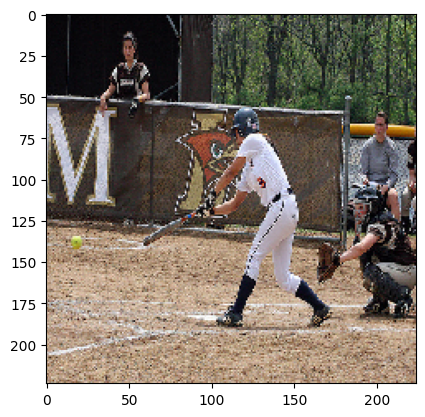

In [31]:
img, prediction = get_prediction(image_name="3513362553_5fc5779e20.jpg")
top_pred = [pred[1] for pred in prediction[0]][:2]
gen_caption = generate_sentence(top_pred, max_new_tokens=20)
plt.imshow(img)
print(f"Generated caption : {gen_caption}")
print(f"Top prediction : {top_pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Generated caption : The following is a list of the drivers that are responsible for the bridge.
Top prediction : ['suspension_bridge', 'bannister']


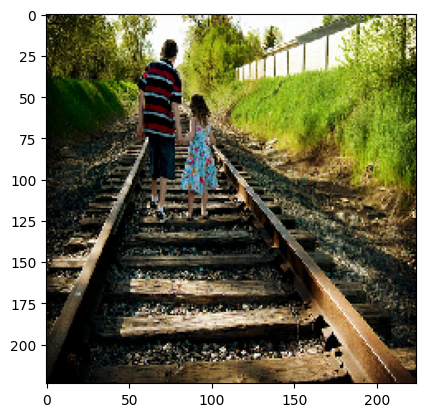

In [32]:
img, prediction = get_prediction(image_name="3514188115_f51932ae5d.jpg")
top_pred = [pred[1] for pred in prediction[0]][:2]
gen_caption = generate_sentence(top_pred, max_new_tokens=20)
plt.imshow(img)
print(f"Generated caption : {gen_caption}")
print(f"Top prediction : {top_pred}")

#### Using image similarity

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Caption from database : black brown dog chewing stick
Generated caption : The dog was found in a wooded area near the intersection of West and West Streets.


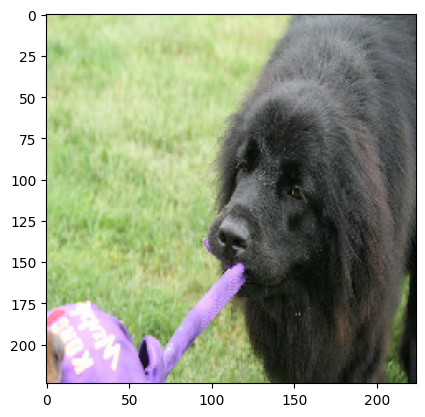

In [33]:
img, caption = get_caption(image_name = "3511062827_cd87871c67.jpg")
caption_ls = caption.split(" ")
gen_caption = generate_sentence(caption_ls, max_new_tokens=20)
plt.imshow(img)
print(f"Caption from database : {caption}")
print(f"Generated caption : {gen_caption}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Caption from database : blonde haired girl obama shirt smiling camera
Generated caption : The girl is wearing a black and white striped shirt with a black and white striped collar.


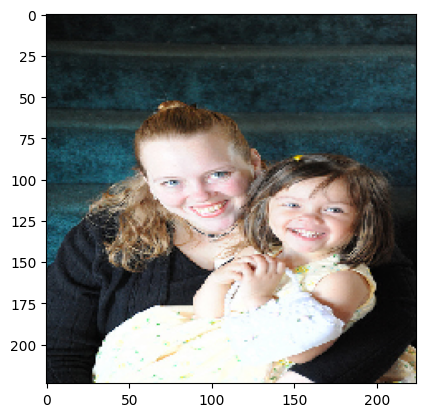

In [34]:
img, caption = get_caption(image_name = "3512791890_eb065b460a.jpg")
caption_ls = caption.split(" ")
gen_caption = generate_sentence(caption_ls, max_new_tokens=20)
plt.imshow(img)
print(f"Caption from database : {caption}")
print(f"Generated caption : {gen_caption}")